## Forecasting with Prophet

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing necessary libraries

import pandas as pd
import numpy as np
from datetime import datetime

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from prophet import Prophet

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Numerical Dataset Curation/Meteorological_Data.csv")

In [ ]:
def preprocess_dataframe(df):
  """
  params:
  - df (dataframe): dataframe before preprocessing
  does:
  - Transform 'DATETIME' column from object to datetime format with renaming of column to timestamp.
  - Remove Outliers
  -Timestamp can be changed to index
  returns: Processed df (dataframe)
  """
  df['Timestamp'] = pd.to_datetime(df['DATETIME'])
  df.set_index('Timestamp', inplace=True) # set timestamp as index
  df=df.drop(['DATETIME', 'Avg Solar Eclipse Shading'], axis=1) # Remove null columns
  df = df[df["Avg CDOC Total Cloud Cover [%]"] !=-99999 ] # remove outliers
  return df

In [ ]:
df=preprocess_dataframe(data)

#Selecting Features based on Feature Selection and then Modeling

In [ ]:
cols_to_keep = ['Avg Zenith Angle [degrees]','Avg Sun Flag','Avg Opaque Cloud Cover [%]','Avg Blue/Red_min','Avg Global CMP22 (vent/cor) [W/m^2]','Avg BRBG Total Cloud Cover [%]','Avg Azimuth Angle [degrees]','Avg Albedo (CMP11)','Avg Tower Dew Point Temp [deg C]','Avg Total Cloud Cover [%]']
data_df=df.loc[:, cols_to_keep]
data_df = data_df.reset_index()
data_df = data_df.rename(columns={"Timestamp": "ds", "Avg Global CMP22 (vent/cor) [W/m^2]": "y"})

In [ ]:
#TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(data_df):
    train = data_df.iloc[train_index]
    valid = data_df.iloc[test_index]

#initialize the model
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

# Define the parameter grid for tuning
# Define the parameter grid for tuning
param_grid = {
    'seasonality_mode': ['additive'],
    'seasonality_prior_scale': [0.1]}

# Create a list of parameter combinations
param_combinations = list(ParameterGrid(param_grid))

# Initialize variables to store the best model and its performance
best_model = None
best_rmse = float('inf')
best_mse = float('inf')

# Set the timestamp column as the index
data_df.set_index('ds', inplace=True)

# Ensure that your data is sorted by timestamp
data_df.sort_index(inplace=True)

min_train_size =2000  # Minimum training data points to start with

# Define lists to store evaluation metrics
all_rmses = []
all_mses = []
all_forecasts = []  # Add this line to store forecasts

In [ ]:
data_df = data_df.reset_index()

## Rolling Window Training

DO NOT RUN - Starting to Train

In [ ]:
for i in range(min_train_size, len(data_df) + 1):
    train = data_df.iloc[:i]
    val = data_df.iloc[i:i + 1]

    # Loop through parameter combinations and evaluate performance
    for params in param_combinations:
        model = Prophet(**params)
        model.fit(train)  # Use your training data

        # Make predictions on the validation set
        #future = model.make_future_dataframe(periods=len(df_validation))
        forecast = model.predict(val)

        # Calculate RMSE on the validation set
        rmse = mean_squared_error(val['y'], forecast['yhat'], squared=False)

        # Calculate evaluation metrics (e.g., MSE or MAE)
        mse = mean_squared_error(val['y'], forecast['yhat'])
        #print(f"Mean Squared Error (MSE): {mse}")

        all_rmses.append(rmse)
        all_mses.append(mse)
        all_forecasts.append(forecast)

        # Check if this model has a lower RMSE
        if rmse < best_rmse and mse < best_mse:
            best_rmse = rmse
            best_mse = mse
            best_model = model

In [ ]:
import pickle
# After finding the best model
if best_model:
    print(f"Best Model Parameters: {best_model}")
    with open('/content/drive/MyDrive/Forecasting Models/Prophetbest_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

Best Model Parameters: <prophet.forecaster.Prophet object at 0x788847f11900>


In [ ]:
# After the loop, you can calculate additional evaluation metrics if needed
print(f"Best RMSE: {best_rmse}")
print(f"Best MSE: {best_mse}")
print(f"Best Model Parameters: {best_model}")
print("Best Model Parameters:")
print(f"Seasonality Mode: {best_model.seasonality_mode}")
print(f"Seasonality Prior Scale: {best_model.seasonality_prior_scale}")

Best RMSE: 0.010775562618448475
Best MSE: 0.00011611274974410416
Best Model Parameters: <prophet.forecaster.Prophet object at 0x788847f11900>
Best Model Parameters:
Seasonality Mode: additive
Seasonality Prior Scale: 0.1


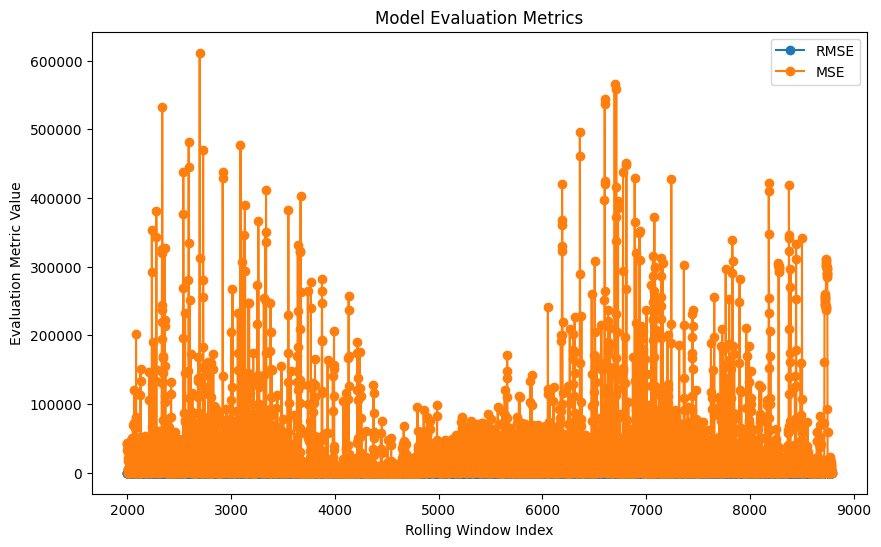

In [ ]:
start_index = 2000
end_index = start_index + len(all_mses)

# Create the x values for the plot
x_values = range(start_index, end_index)

# Plot RMSE and MSE
plt.figure(figsize=(10, 6))
plt.plot(x_values,all_rmses, label='RMSE', marker='o')
plt.plot(x_values,all_mses, label='MSE', marker='o')
plt.xlabel('Rolling Window Index')
plt.ylabel('Evaluation Metric Value')
plt.legend()
plt.title('Model Evaluation Metrics')
plt.show()

In [ ]:
# Plotting the actual vs forecasted values
for forecasted in all_forecasts:
    plt.figure()
    plt.plot(data_df['y'], label='Actual')  # Replace 'y' with the actual column name for values
    plt.plot(forecasted, label='Forecasted')
    plt.legend()
    plt.show()